In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=9735ab5ad324eda65d4ff37ea00249875c5c85bf3eee2b92ed5fc475368aa5e3
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("num_of_hackers").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/15 02:56:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.csv("../input/sample-hack-data/hack_data.csv", header=True, inferSchema=True)

In [5]:
df.show(2)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                      8|           391.09|              1|             2.96|              7|            Slovenia|           72.37|
|                     20|           720.99|              0|             3.04|              9|British Virgin Is...|           69.08|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
only showing top 2 rows



In [6]:
round(df.describe().toPandas(), 2)

,summary,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed
0,count,334,334,334,334,334,334,334
1,mean,30.008982035928145,607.2452694610777,0.5119760479041916,5.258502994011977,10.838323353293413,None,57.342395209580864
2,stddev,14.088200614636158,286.33593163576757,0.5006065264451406,2.30190693339697,3.06352633036022,None,13.41106336843464
3,min,1,10.0,0,1.0,6,Afghanistan,40.0
4,max,60,1330.5,1,10.0,15,Zimbabwe,75.0


In [7]:
from pyspark.ml.feature import VectorAssembler

In [8]:
df.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

In [9]:
feat_cols = ['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'WPM_Typing_Speed']

In [10]:
assembler = VectorAssembler(inputCols=feat_cols, outputCol='features')

In [11]:
final_df = assembler.transform(df)

In [12]:
from pyspark.ml.feature import StandardScaler

In [13]:
scaler = StandardScaler(inputCol='features', 
                        outputCol='scaled_feat',
                        withStd = True,
                        withMean = False)

In [14]:
scaled_model = scaler.fit(final_df)

In [15]:
cluster_df = scaled_model.transform(final_df)

In [16]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [17]:
eval = ClusteringEvaluator(predictionCol="prediction",
                           featuresCol="scaled_feat",
                           metricName="silhouette",
                           distanceMeasure="squaredEuclidean")

In [18]:
silhouette_score = []
print("""
Silhoutte Scores for K Mean Clustering
======================================
Model\tScore\t
=====\t=====\t
""")
for k in range(2,11):
  kmeans_algo = KMeans(featuresCol='scaled_feat',k=k)
  kmeans_fit = kmeans_algo.fit(cluster_df)
  output = kmeans_fit.transform(cluster_df)
  score = eval.evaluate(output)
  silhouette_score.append(score)
  print(f"K{k}\t{round(score,2)}\t")



Silhoutte Scores for K Mean Clustering
Model	Score	
=====	=====	

K2	0.82	
K3	0.76	
K4	0.72	
K5	0.64	
K6	0.53	
K7	0.47	
K8	0.46	
K9	0.48	
K10	0.47	


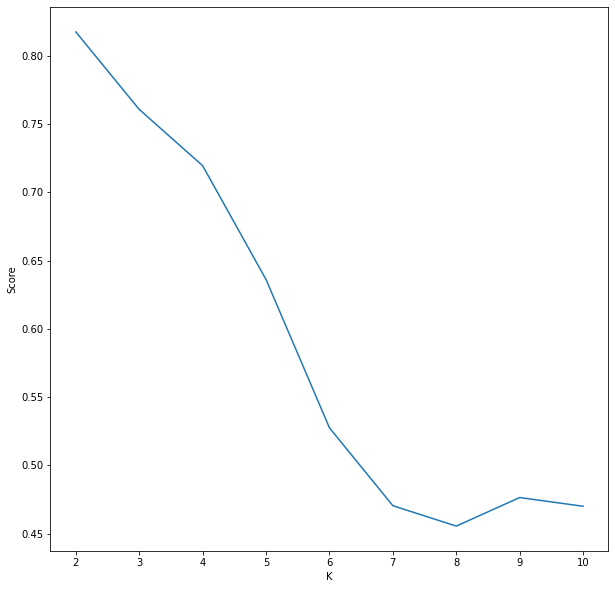

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(range(2,11), silhouette_score)
ax.set_xlabel("K")
ax.set_ylabel("Score");